In [2058]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter, defaultdict
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('tagsets_json')

# remove warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets_json to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets_j

In [2059]:
np.random.seed(500)

In [2060]:
# Load the data
Corpus = pd.read_csv('data/data.csv')

In [2061]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  671 non-null    object
 1   fulltext  613 non-null    object
dtypes: object(2)
memory usage: 10.6+ KB


In [2062]:
Corpus.head()

,category,fulltext
0,accountability,United Nations A/60/846/Add.6 Gener...
1,accountability,United Nations A/71/729 General Asse...
2,accountability,United Nations A/72/492 General Asse...
3,accountability,United Nations A/72/492/Add.2 Genera...
4,accountability,United Nations A/73/688 General Asse...


In [2063]:
Corpus["category"].value_counts()

category
human resources               466
travel                         78
accountability                 42
security                       35
finance and budget             17
information and technology     14
health and wellbeing           11
property management             8
Name: count, dtype: int64

In [2064]:
Corpus.isnull().sum()

category     0
fulltext    58
dtype: int64

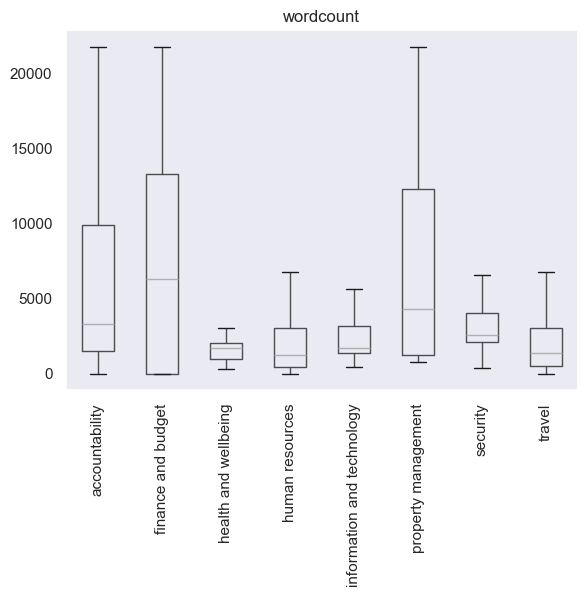

In [2065]:
# How long are the texts in the dataset?
Corpus["wordcount"] = Corpus["fulltext"].apply(lambda x: len(str(x).split(" ")))
# plot wordcount per category
Corpus.boxplot("wordcount", by="category", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()




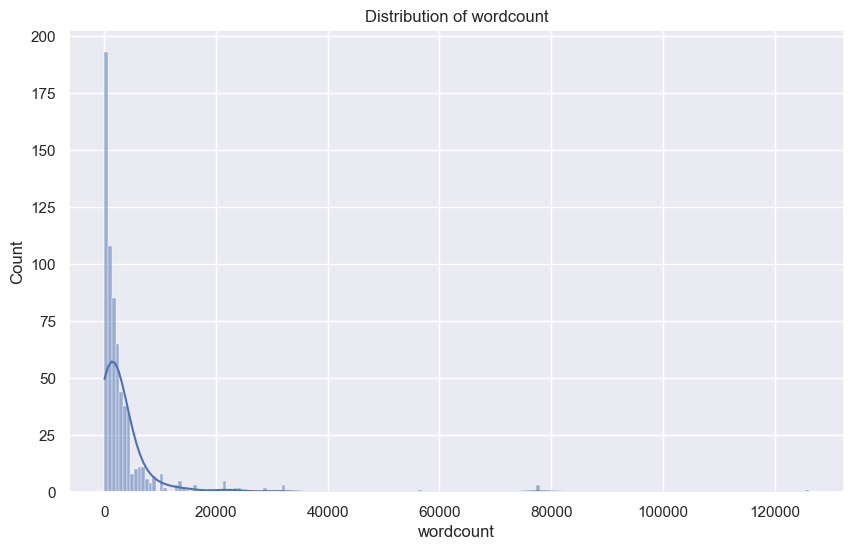

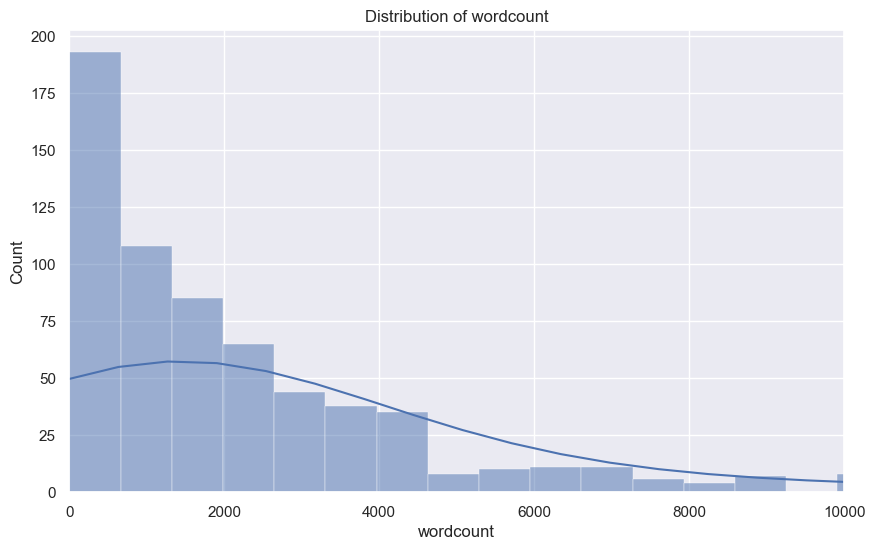

In [2066]:
# plot distribution of wordcount
plt.figure(figsize=(10, 6))
sns.histplot(Corpus["wordcount"], kde=True)
plt.title("Distribution of wordcount")
plt.show()
# zoom in on the distribution of wordcount
plt.figure(figsize=(10, 6))
sns.histplot(Corpus["wordcount"], kde=True)
plt.xlim(0, 10000)
plt.title("Distribution of wordcount")
plt.show()


Majority of the documents are less than 5000 words so we will only retain those after data cleaning.

In [2067]:
Corpus

,category,fulltext,wordcount
0,accountability,United Nations A/60/846/Add.6 Gener...,8881
1,accountability,United Nations A/71/729 General Asse...,10917
2,accountability,United Nations A/72/492 General Asse...,16716
3,accountability,United Nations A/72/492/Add.2 Genera...,126181
4,accountability,United Nations A/73/688 General Asse...,14427
...,...,...,...
666,travel,United Nations ST/IC/2001/27 Secretariat 10 ...,4542
667,travel,United Nations ST/IC/2001/27/Amend.1 ...,305
668,travel,United Nations ST/IC/2001/27 Secre...,5463
669,travel,United Nations ST/AI/2000/19 Secret...,4049


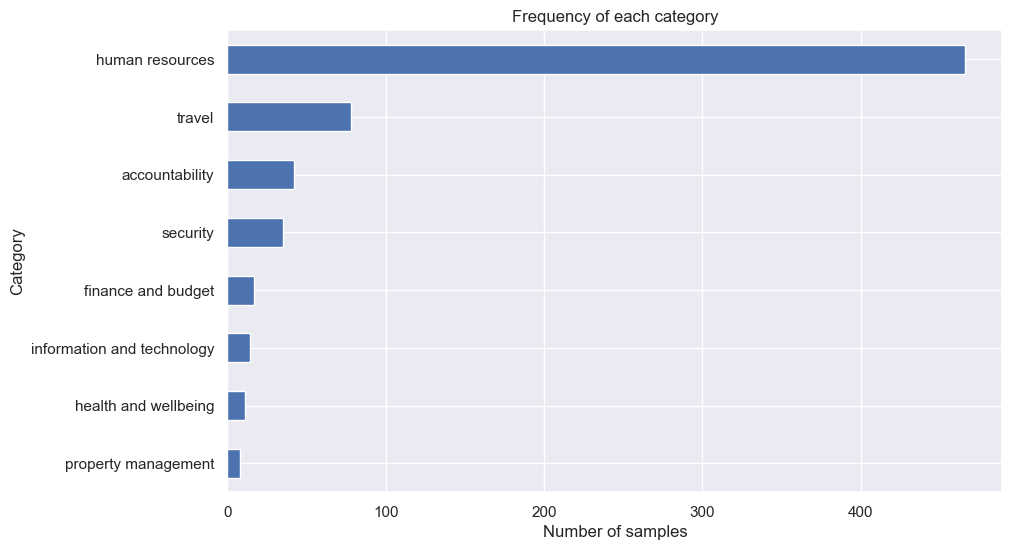

In [2068]:
# show category distribution bar horizontal
Corpus["category"].value_counts(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of samples')
plt.ylabel('Category')
plt.title('Frequency of each category')
plt.show()


As we can see from the category distribution, we have an imbalance data set. We will have to address before training the model. We will use the F1 score for the metric instead of accuracy.

### Data Pre-processing

1. Remove rows with blank values
Remove rows where wordcount > 5000
2. Change all to lower case
3. Tokenization
4. Remove stop words
5. Remove non-alpha text
6. Word Lemmatization


In [2069]:
Corpus.isnull().sum()

category      0
fulltext     58
wordcount     0
dtype: int64

In [2070]:
Corpus.dropna(inplace=True)

In [2071]:
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [2072]:
def stemmer(text):
    stem = PorterStemmer()
    return ' '.join([stem.stem(w) for w in word_tokenize(text)])

In [2073]:
Corpus['fulltext'] = Corpus['fulltext'].apply(stemmer)

In [2074]:
# To speed up execution while testing, we can reduce the number of samples
#Corpus = Corpus.sample(frac=0.6)

# Remove rows where wordcount is greater than 50000
#Corpus = Corpus[Corpus['wordcount'] < 5000]
# Step 2: Change all the text to lower case
#Corpus['fulltext'] = [entry.lower() for entry in Corpus['fulltext']]
# Step 3: Tokenization : In this each entry in the corpus will be broken into set of words
#Corpus['fulltext'] = [word_tokenize(entry) for entry in Corpus['fulltext']]
# Step 4: Remove stop words, non-alphabet and perfom word lemmatization
#tag_map = defaultdict(lambda : wn.NOUN)
#tag_map['J'] = wn.ADJ
#tag_map['V'] = wn.VERB
#tag_map['R'] = wn.ADV
#for index,entry in enumerate(Corpus['fulltext']):
#    Final_words = []
#    #word_Lemmatized = WordNetLemmatizer()
#    #if index == 179: print(index, entry)
#    for word in entry:
#        #print(word, tag)
#        # remove stopwords, non-alphabet and words with length less than 3 e.g. abbreviations, roman numerals
#        if word not in stopwords.words('english') and word.isalpha():
#            # we will only add nouns in the final text
#            #word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#            #if index == 179: print(word)
#            Final_words.append(word)
#    print(Corpus.iloc[index].category)
#    #Corpus.loc[index,'text_final'] = " ".join(Final_words)
    
Corpus.head()

,category,fulltext,wordcount
0,accountability,unit nation a/60/846/add.6 gener assembl distr...,8881
1,accountability,unit nation a/71/729 gener assembl distr . : g...,10917
2,accountability,unit nation a/72/492 gener assembl distr . : g...,16716
3,accountability,unit nation a/72/492/add.2 gener assembl distr...,126181
4,accountability,unit nation a/73/688 gener assembl distr . : g...,14427


In [2075]:
# Check number of rows for missing values
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [2076]:
# show record in Corpus with nan values
Corpus[Corpus.isnull().any(axis=1)]

,category,fulltext,wordcount


In [2077]:
# Remove rows with empty fields
Corpus = Corpus.dropna()

In [2078]:
# Re-check number of rows for missing values
Corpus.isnull().sum()

category     0
fulltext     0
wordcount    0
dtype: int64

In [2079]:
Corpus["category"].value_counts()

category
human resources               417
travel                         77
accountability                 40
security                       35
information and technology     14
finance and budget             11
health and wellbeing           11
property management             8
Name: count, dtype: int64

### Prepare Train and Test Data

In [2080]:
# Prepare test data
X_train, X_test, y_train, y_test = train_test_split(Corpus['fulltext'], Corpus['category'], test_size=0.3, stratify=Corpus['category'].values)

In [2081]:
# show value counts for training set
y_train.value_counts()

category
human resources               292
travel                         54
accountability                 28
security                       24
information and technology     10
health and wellbeing            8
finance and budget              8
property management             5
Name: count, dtype: int64

In [2082]:
# show value counts for test set
y_test.value_counts()

category
human resources               125
travel                         23
accountability                 12
security                       11
information and technology      4
health and wellbeing            3
finance and budget              3
property management             3
Name: count, dtype: int64

In [2083]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({'human resources': 292, 'travel': 54, 'accountability': 28, 'security': 24, 'information and technology': 10, 'health and wellbeing': 8, 'finance and budget': 8, 'property management': 5})


### Encode category

In [2084]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [2085]:
# Define labels and target names
labels = [0, 1, 2, 3, 4, 5, 6, 7]
target_names = ['accountability', 'finance and budget', 'health and wellbeing', 'human resources', 'information and technology', 'property management', 'security', 'travel']

In [2086]:
# Define Pipelines using CountVectorizer

# Baseline
cvect_base_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                                ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                                ('dclass', DummyClassifier(strategy='stratified'))])

# Logistic Regression
cvect_log_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                               ('log', LogisticRegression(max_iter=10000))])

# Naive Bayes
cvect_nb_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                              ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                              ('nb', MultinomialNB())])

# SVM
cvect_svm_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                               ('svm', SVC())])

In [2087]:
# Define Pipelines using TfidfVectorizer

# Baseline
tvect_base_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                                ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                                ('dclass', DummyClassifier(strategy='stratified'))])

# Logistic Regression
tvect_log_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                                ('log', LogisticRegression(max_iter=10000))])

# Naive Bayes
tvect_nb_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                              ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                              ('nb', MultinomialNB())])

# SVM
cvect_svm_pipeline = Pipeline([('vect', CountVectorizer(stop_words='english', token_pattern=r'\b[^\d\W]+\b')),
                               ('resample', SMOTETomek(sampling_strategy='auto',smote=SMOTE(k_neighbors=2),tomek=TomekLinks())),
                               ('svm', SVC())])

In [2088]:
# Define parameters for GridSearchCV

# CountVectorizer - Logistic Regression
log_param = {'vect__max_features': [100, 500, 1000, 2000],
             'log__C': [0.1, 1, 10, 100]}

# CountVectorizer - Naive Bayes
nb_param = {'vect__max_features': [100, 500, 1000, 2000],
             'nb__alpha': [0.1, 1, 10, 100]}

# CountVectorizer - SVM
svm_param = {'vect__max_features': [100, 500, 1000, 2000],
             'svm__C': [0.1, 1, 10, 100]}

In [2089]:
# Function to train and evaluate models
def train_eval_model(pipeline, X_train, y_train, X_test, y_test, target_names, labels):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(pipeline.named_steps)
    print(classification_report(y_test, y_pred, target_names=target_names, labels=labels))
    

In [2090]:
# Function to train and tune models
def train_tune_model(pipeline, X_train, y_train, X_test, y_test, target_names, labels, param_grid):
    grid = GridSearchCV(pipeline, param_grid)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print(pipeline.named_steps)
    print(grid.best_params_)
    print(classification_report(y_test, y_pred, target_names=target_names, labels=labels))

### Evaluate models using CountVectorizer for feature extraction

#### Default parameters

In [2091]:
# Baseline
train_eval_model(cvect_base_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'dclass': DummyClassifier(strategy='stratified')}
                            precision    recall  f1-score   support

            accountability       0.06      0.17      0.09        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       0.00      0.00      0.00         3
           human resources       0.56      0.07      0.13       125
information and technology       0.00      0.00      0.00         4
       property management       0.00      0.00      0.00         3
                  security       0.05      0.09      0.06        11
                    travel       0.21      0.13      0.16        23

                  accuracy                           0.08       184
                 macro avg       0.11      0.06      0.05       184
              weighted avg       0.42      0.0

In [2092]:
# Logistic Regression
train_eval_model(cvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
                            precision    recall  f1-score   support

            accountability       0.40      0.33      0.36        12
        finance and budget       0.14      0.33      0.20         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.72      0.78      0.75       125
information and technology       0.00      0.00      0.00         4
       property management       0.00      0.00      0.00         3
                  security       0.83      0.91      0.87        11
                    travel       0.00      0.00      0.00        23

                  accuracy                           0.61       184
                 macro avg       0.39      0.34      0.34       184
              weighted avg       0.59      0.61      

In [2093]:
# Naive Bayes
train_eval_model(cvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
                            precision    recall  f1-score   support

            accountability       0.38      0.83      0.53        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.86      0.65      0.74       125
information and technology       0.40      0.50      0.44         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.41      0.65      0.50        23

                  accuracy                           0.65       184
                 macro avg       0.49      0.50      0.45       184
              weighted avg       0.74      0.65      0.67       184



In [2094]:
# SVM
train_eval_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels)


{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
                            precision    recall  f1-score   support

            accountability       0.62      0.67      0.64        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       0.67      0.67      0.67         3
           human resources       0.90      0.52      0.66       125
information and technology       0.60      0.75      0.67         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.29      0.87      0.43        23

                  accuracy                           0.59       184
                 macro avg       0.49      0.56      0.50       184
              weighted avg       0.76      0.59      0.62       184



#### Tune hyperparameters

In [2095]:
# Logistic Regression
train_tune_model(cvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels, log_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
{'log__C': 100, 'vect__max_features': 2000}
                            precision    recall  f1-score   support

            accountability       0.45      0.42      0.43        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.73      0.78      0.76       125
information and technology       0.00      0.00      0.00         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.06      0.04      0.05        23

                  accuracy                           0.63       184
                 macro avg       0.39      0.32      0.33       184
         

In [2096]:
# Naive Bayes
train_tune_model(cvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels, nb_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
{'nb__alpha': 0.1, 'vect__max_features': 2000}
                            precision    recall  f1-score   support

            accountability       0.36      0.75      0.49        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       0.00      0.00      0.00         3
           human resources       0.83      0.64      0.72       125
information and technology       0.40      0.50      0.44         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.39      0.65      0.49        23

                  accuracy                           0.64       184
                 macro avg       0.35      0.44      0.38       184
              weighted avg

In [2097]:
# SVM
train_tune_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels, svm_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
{'svm__C': 100, 'vect__max_features': 500}
                            precision    recall  f1-score   support

            accountability       0.56      0.42      0.48        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.78      0.75      0.77       125
information and technology       0.00      0.00      0.00         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.31      0.43      0.36        23

                  accuracy                           0.66       184
                 macro avg       0.44      0.37      0.38       184
              weighted avg       0.67  

### Evaluate models using TfidfVectorizer feature extraction

#### Default parameters

In [2098]:
# Baseline
train_eval_model(tvect_base_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'dclass': DummyClassifier(strategy='stratified')}
                            precision    recall  f1-score   support

            accountability       0.05      0.08      0.06        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       0.00      0.00      0.00         3
           human resources       0.74      0.11      0.19       125
information and technology       0.09      0.50      0.15         4
       property management       0.00      0.00      0.00         3
                  security       0.14      0.36      0.21        11
                    travel       0.09      0.13      0.11        23

                  accuracy                           0.13       184
                 macro avg       0.14      0.15      0.09       184
              weighted avg       0.53      0.1

In [2099]:
# Logistic Regression
train_eval_model(tvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
                            precision    recall  f1-score   support

            accountability       0.57      0.67      0.62        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.83      0.74      0.78       125
information and technology       0.50      0.50      0.50         4
       property management       0.00      0.00      0.00         3
                  security       0.92      1.00      0.96        11
                    travel       0.35      0.52      0.42        23

                  accuracy                           0.68       184
                 macro avg       0.52      0.47      0.47       184
              weighted avg       0.73      0.68      

In [2100]:
# Naive Bayes
train_eval_model(tvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
                            precision    recall  f1-score   support

            accountability       0.18      0.92      0.31        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.93      0.30      0.46       125
information and technology       0.50      1.00      0.67         4
       property management       0.00      0.00      0.00         3
                  security       0.79      1.00      0.88        11
                    travel       0.39      0.87      0.54        23

                  accuracy                           0.46       184
                 macro avg       0.47      0.55      0.42       184
              weighted avg       0.76      0.46      0.47       184



In [2101]:
# SVM
train_eval_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
                            precision    recall  f1-score   support

            accountability       0.62      0.67      0.64        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       0.67      0.67      0.67         3
           human resources       0.87      0.54      0.67       125
information and technology       0.60      0.75      0.67         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.30      0.83      0.44        23

                  accuracy                           0.60       184
                 macro avg       0.49      0.56      0.50       184
              weighted avg       0.74      0.60      0.63       184



#### Tune hyperparameters

In [2102]:
# Logistic Regression
train_tune_model(tvect_log_pipeline, X_train, y_train, X_test, y_test, target_names, labels, log_param)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'log': LogisticRegression(max_iter=10000)}
{'log__C': 0.1, 'vect__max_features': 2000}
                            precision    recall  f1-score   support

            accountability       0.47      0.75      0.58        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       0.50      0.33      0.40         3
           human resources       0.85      0.69      0.76       125
information and technology       0.50      0.75      0.60         4
       property management       0.00      0.00      0.00         3
                  security       0.92      1.00      0.96        11
                    travel       0.39      0.61      0.47        23

                  accuracy                           0.67       184
                 macro avg       0.45      0.52      0.47       184
         

In [2103]:
# Naive Bayes
train_tune_model(tvect_nb_pipeline, X_train, y_train, X_test, y_test, target_names, labels, nb_param)

{'vect': TfidfVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'nb': MultinomialNB()}
{'nb__alpha': 0.1, 'vect__max_features': 500}
                            precision    recall  f1-score   support

            accountability       0.37      0.83      0.51        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.88      0.62      0.72       125
information and technology       0.33      0.50      0.40         4
       property management       0.00      0.00      0.00         3
                  security       0.92      1.00      0.96        11
                    travel       0.43      0.78      0.55        23

                  accuracy                           0.65       184
                 macro avg       0.49      0.51      0.46       184
              weighted avg 

In [2104]:
# SVM
train_tune_model(cvect_svm_pipeline, X_train, y_train, X_test, y_test, target_names, labels, svm_param)

{'vect': CountVectorizer(stop_words='english', token_pattern='\\b[^\\d\\W]+\\b'), 'resample': SMOTETomek(smote=SMOTE(k_neighbors=2), tomek=TomekLinks()), 'svm': SVC()}
{'svm__C': 100, 'vect__max_features': 1000}
                            precision    recall  f1-score   support

            accountability       0.57      0.33      0.42        12
        finance and budget       0.00      0.00      0.00         3
      health and wellbeing       1.00      0.33      0.50         3
           human resources       0.80      0.78      0.79       125
information and technology       0.33      0.25      0.29         4
       property management       0.00      0.00      0.00         3
                  security       0.85      1.00      0.92        11
                    travel       0.38      0.48      0.42        23

                  accuracy                           0.68       184
                 macro avg       0.49      0.40      0.42       184
              weighted avg       0.70 